In [1]:
#Блок в рамках которого импотряться математические подсчеты, падас и нампай
import pandas as pd
import numpy as np
from scipy.stats import iqr
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis
import scipy.stats
import scipy as sp


import os
#Блок в рамках которого импотряться графики
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.pyplot import figure
sns.set_style('darkgrid')


#Блок в рамках которого импотряться статистические пакеты
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import het_white, het_goldfeldquandt, het_breuschpagan
from statsmodels.stats.outliers_influence import reset_ramsey
from statsmodels.stats.diagnostic import compare_encompassing 

# Содержание работы

[Обработка и получение данных](#Introduction)
#### Выполнение заданий:
1. [Задание 1](#subparagraph1) -  Оценка линейной модели
2. [Задание 2](#subparagraph2) - Оценка полулогорифмической модели
3. [Задание 3](#subparagraph3) - Оценка линейной в логарифмах модели
4. [Задание 4](#subparagraph4) - Выбор модели (Тест Бокса-Кокса с преообразованием Зарембки)
5. [Задание 5](#subparagraph5) - Тестирование различия в ЗП (Тест Чоу)
6. [Задание 6](#subparagraph6) - Тестирование наличие выборосов (DFbettas, Leverage, Dffits)
7. [Задание 7](#subparagraph7) - Поиск мультиколлиниарности (VIF)
8. [Задание 8](#subparagraph8) - Применение PCA
9. [Задание 9](#subparagraph9) - Построение графика остатки-прогнозы
10. [Задание 10](#subparagraph10) - Тестирование гетероскедостичности (Тест Уйта, Голдфелда — Куандта, Бройша — Пагана
11. [Задание 11](#subparagraph11) - Проведение Теста Рамсея
12. [Задание 12](#subparagraph12) - Оценка и сравнение модели
13. [Задание 13](#subparagraph13) - Предложение функциональных форм
14. [Задание 14](#subparagraph14) - Итоговая оценка модели

### 0. Предварительный EDA

In [2]:
# making "directoryback"
os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir))

In [3]:
data = pd.read_csv('Data/PhonesDF_years.csv')
data.sample(3)

,phone_title,price,rating,specs_score,likes,disp_diag,camera,storage,ram,battery_capacity,battery_type,disp_height,disp_width,oper_syst_type,oper_syst_vers,brand,year_of_release
813,Huawei Y6 Pro (2019),30999.0,4.1,47,46,6.09,8.0,32.0,3.0,3020.0,Li-Ion,1560.0,720.0,Android,9,Huawei,2019
103,Tecno Camon X,11499.0,3.9,56,77,6.00,20.0,16.0,3.0,3750.0,Li-Po,1440.0,720.0,Android,8,Tecno,2017
752,Infinix Hot 6X 32GB,15000.0,3.0,46,27,6.20,8.0,32.0,3.0,4000.0,Li-Ion,1500.0,720.0,Android,8,Infinix,2018


In [4]:
# adding log price and PPI to dataset
data['log_price'] = np.log(data.price)
data['density'] = data.disp_height * data.disp_width / data.disp_diag

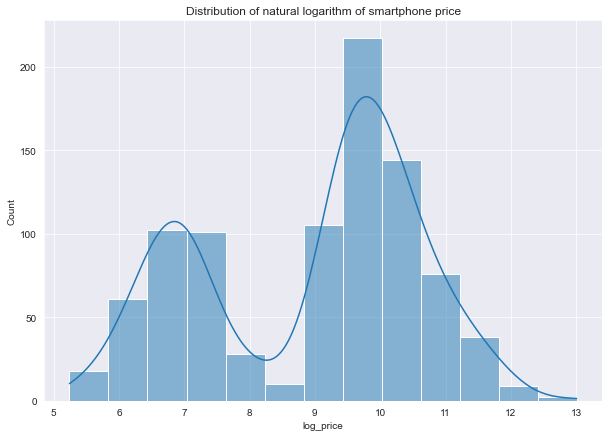

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=data, x='log_price', ax=ax,  kde=True)
ax.set_title('Distribution of natural logarithm of smartphone price');

Видно, что у нас получилось бимодальное распределение, где каждый колокол напомоминает нормальное распределение. Скорее всего, это связано с тем, что у нас в датасете есть много некорректно указанных цен (ошибка с порядком цены), так как в левой части распределения телефоны имеют цену ниже 2000 рублей, что выглядит неправдоподобно.

Избавимся от этих выбросов и построим новое распределение цены:

In [6]:
# correcting and saving data
data = data.loc[(data.price >= np.exp(8.3)) & (data.price < np.exp(12.5)), :].copy(deep=True)
data.to_csv('Data/PhonesDF_years_corrected.csv', index=False)

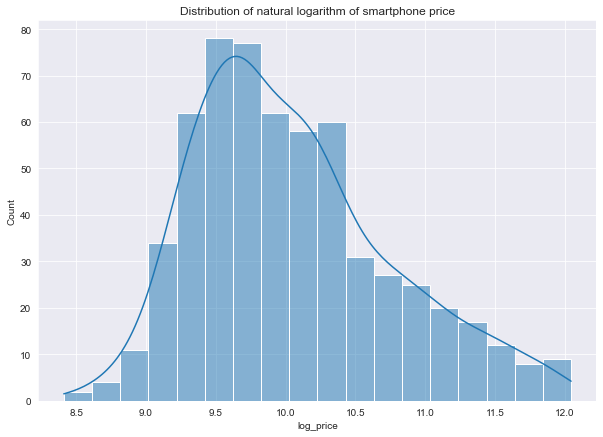

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=data, x='log_price', ax=ax,  kde=True)
ax.set_title('Distribution of natural logarithm of smartphone price');

Видно, что распределение логарифма цены имеет правостороннюю ассиметрию.

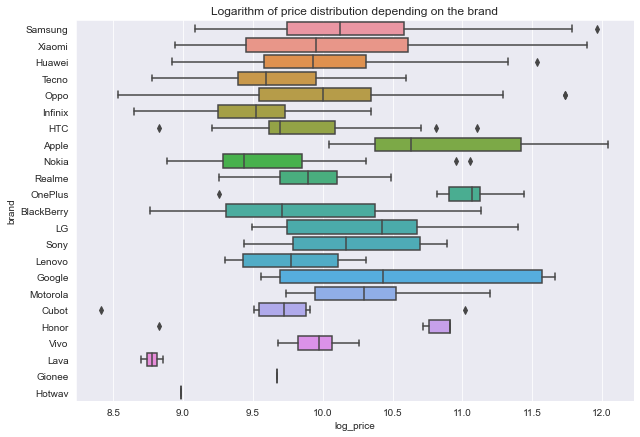

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(data=data, y='brand', x='log_price', ax=ax, order=list(data.brand.value_counts().index))
ax.set_title('Logarithm of price distribution depending on the brand');

Видно, что айфоны и смартфоны бренда Google сущестсвенно дороже, чем остальные.

Построим, как цена и ее логарифм зависит от числовых характеристик смартфона.

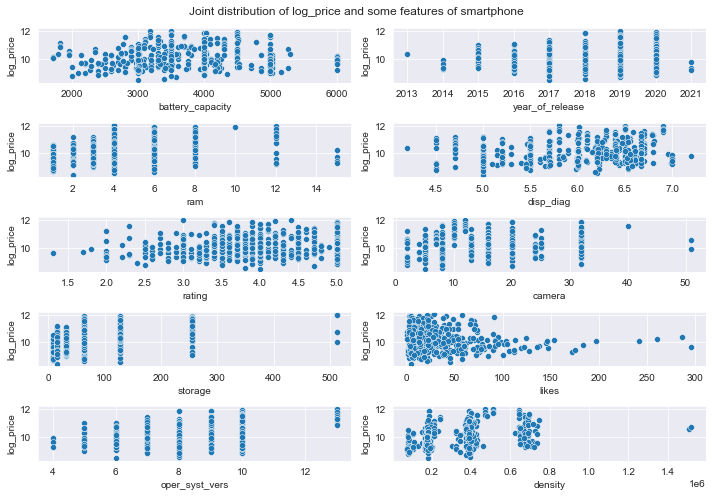

In [9]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    sns.scatterplot(data=data, x=col, y='log_price', ax=ax[i // 2][i % 2])
fig.suptitle('Joint distribution of log_price and some features of smartphone')
plt.tight_layout();

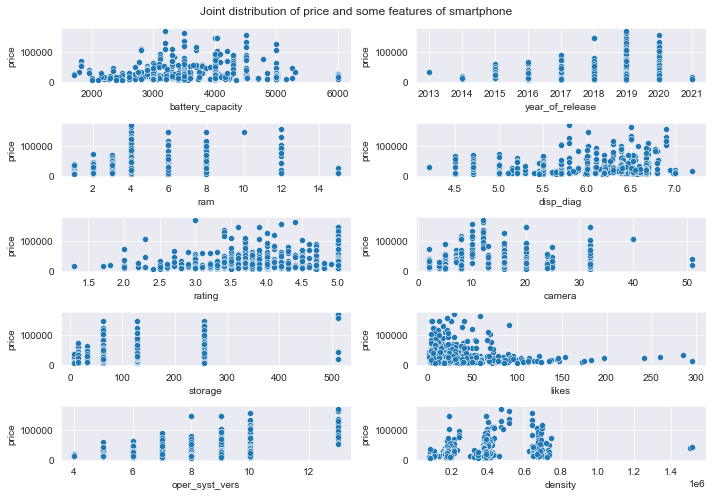

In [10]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    sns.scatterplot(data=data, x=col, y='price', ax=ax[i // 2][i % 2])
fig.suptitle('Joint distribution of price and some features of smartphone')
plt.tight_layout();

Таким образом, явной линейной и логлинейной звисимости тут не прослеживается. Попробуем отлогарифмировать признаки.

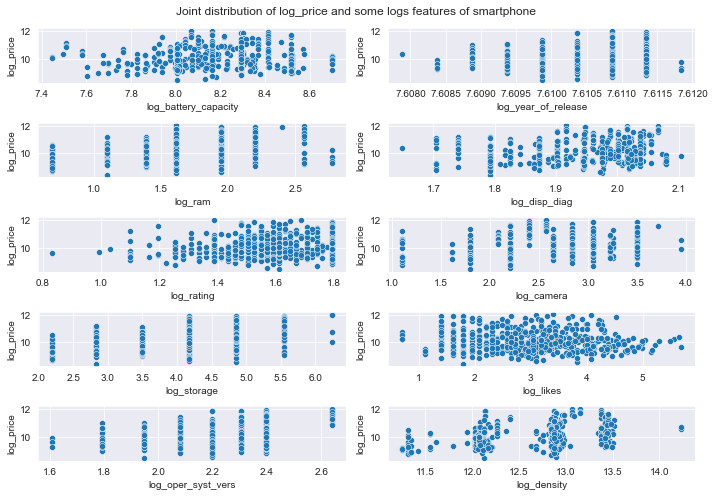

In [11]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    ax_cur = ax[i // 2][i % 2]
    sns.scatterplot(x=np.log1p(data[col]), y=data.log_price, ax=ax_cur)
    ax_cur.set_xlabel('log_' + col)
    ax_cur.set_ylabel('log_price')
fig.suptitle('Joint distribution of log_price and some logs features of smartphone')
plt.tight_layout();

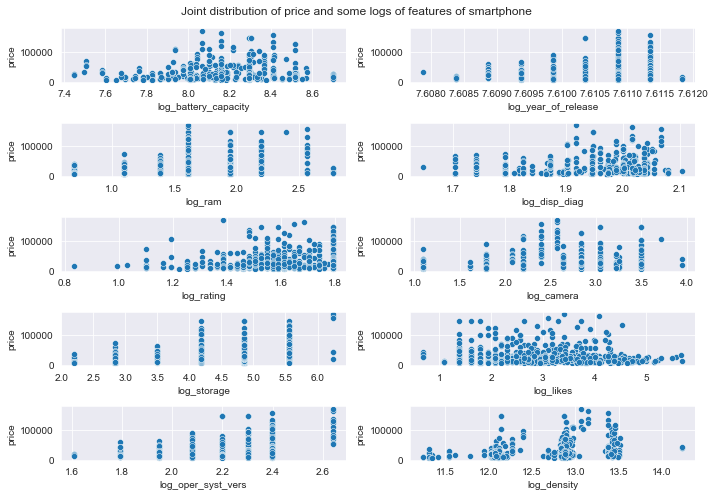

In [12]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    ax_cur = ax[i // 2][i % 2]
    sns.scatterplot(x=np.log1p(data[col]), y=data.price, ax=ax_cur)
    ax_cur.set_xlabel('log_' + col)
    ax_cur.set_ylabel('price')
fig.suptitle('Joint distribution of price and some logs of features of smartphone')
plt.tight_layout();

Явных зависимостей тоже не видно, но это всего лишь проекция данных на 2 оси, так что не стоит отчаиваться!

Посмотрим на корреляции 

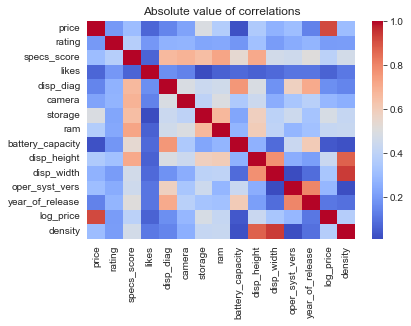

In [13]:
sns.heatmap(np.abs(data.corr()), cmap="coolwarm")
plt.title('Absolute value of correlations');

### 1. Обработка данных

In [14]:
data.sample(3)
data = data.drop(columns = ['price'])

In [15]:
def encode_and_bind(original_dataframe, feature_to_encode, drop = True):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], drop_first = True)
    res = pd.concat([original_dataframe, dummies], axis=1)
    if drop == True:
        res = res.drop(columns = [feature_to_encode])
    return(res)

In [16]:
data = data.set_index('phone_title')
unique_brands = list(data['brand'].unique())

In [17]:
data['Other_oper_syst'] = 0
data['IOS_oper_syst'] = 0

data.loc[data['oper_syst_type'] == 'Other', 'Other_oper_syst'] = 1 # Android - base dummy
data.loc[data['oper_syst_type'] == 'IOS', 'IOS_oper_syst'] = 1 
data = data.drop(columns = ['oper_syst_type'])

In [18]:
data = encode_and_bind(data, 'battery_type')
data = encode_and_bind(data, 'brand')

In [19]:
data = data.rename(columns = {'battery_type_ Li-Po':'battery_type_LiPo'})

In [20]:
data.sample(3)

,rating,specs_score,likes,disp_diag,camera,storage,ram,battery_capacity,disp_height,disp_width,...,brand_Motorola,brand_Nokia,brand_OnePlus,brand_Oppo,brand_Realme,brand_Samsung,brand_Sony,brand_Tecno,brand_Vivo,brand_Xiaomi
phone_title,,,,,,,,,,,,,,,,,,,,,
Sony Xperia L2,3.5,45,14,5.50,8.0,32.0,3.0,3300.0,1280.0,720.0,...,0,0,0,0,0,0,1,0,0,0
Realme 7 6GB/64GB,5.0,100,6,6.50,16.0,64.0,6.0,5000.0,2400.0,1080.0,...,0,0,0,0,1,0,0,0,0,0
Honor 30 6GB/128GB,5.0,91,3,6.53,32.0,128.0,6.0,4000.0,2400.0,1080.0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
from scipy.stats import t
X_columns = data.drop(columns=['log_price', 'IOS_oper_syst', 'oper_syst_vers', 'disp_height', 'disp_width', 'specs_score']).columns

ols = smf.ols(f"log_price ~ {' + '.join(map(str, X_columns))}", data=data).fit()

n = data.shape[0]
k = X_columns.shape[0] + 1
t_crit_r = t.ppf(0.975, n - k - 1)
t_crit_l = -t_crit_r
resid_std = ols.outlier_test()['student_resid']
mask = (resid_std < t_crit_r) & (resid_std > t_crit_l)

data = data[mask]

### 2. EDA

In [22]:
np.round(data.describe(), 2)

,rating,specs_score,likes,disp_diag,camera,storage,ram,battery_capacity,disp_height,disp_width,...,brand_Motorola,brand_Nokia,brand_OnePlus,brand_Oppo,brand_Realme,brand_Samsung,brand_Sony,brand_Tecno,brand_Vivo,brand_Xiaomi
count,561.00,561.00,561.00,561.00,561.00,561.00,561.00,561.00,561.00,561.00,...,561.00,561.00,561.00,561.00,561.00,561.00,561.00,561.00,561.00,561.00
mean,3.84,66.59,29.89,6.00,13.02,82.97,4.45,3755.78,1966.69,985.80,...,0.01,0.04,0.03,0.05,0.03,0.18,0.02,0.08,0.01,0.15
std,0.75,21.27,36.52,0.59,8.65,76.99,2.56,863.63,556.07,277.82,...,0.10,0.19,0.17,0.23,0.18,0.38,0.14,0.27,0.09,0.36
min,1.30,28.00,1.00,4.20,2.00,8.00,1.00,1715.00,480.00,480.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.30,50.00,9.00,5.50,7.00,32.00,3.00,3020.00,1520.00,720.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,3.80,62.00,18.00,6.20,8.00,64.00,4.00,4000.00,1920.00,1080.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,4.40,88.00,37.00,6.50,16.00,128.00,6.00,4200.00,2340.00,1080.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,5.00,100.00,296.00,7.20,51.00,512.00,15.00,6000.00,3840.00,3840.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [23]:
def mean_mode_median(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Function for finding mean median and mode of continious data
    '''
    df = pd.DataFrame()
    df['Mode'] = stats.mode(dataframe)[0][0]
    df['Median'] = np.median(dataframe, axis=0)
    df['Mean'] = np.mean(dataframe, axis=0).to_numpy()
    
    df = np.round(df, 2)
    
    df.index = dataframe.columns
    return df

In [24]:
mean_mode_median(data)

,Mode,Median,Mean
rating,5.00,3.80,3.84
specs_score,100.00,62.00,66.59
likes,4.00,18.00,29.89
disp_diag,5.50,6.20,6.00
camera,8.00,8.00,13.02
storage,128.00,64.00,82.97
ram,4.00,4.00,4.45
battery_capacity,4000.00,4000.00,3755.78
disp_height,2340.00,1920.00,1966.69
disp_width,1080.00,1080.00,985.80


### 3. Multicollinearity

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

data_m = add_constant(data)
data_m = data_m.drop(columns = ['log_price'])
pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns)


c:\Users\Anton\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
c:\Users\Anton\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\Anton\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const                 0.000000
rating                1.356343
specs_score           7.552944
likes                 1.585759
disp_diag             7.565034
camera                2.263473
storage               2.718802
ram                   2.738665
battery_capacity      3.602292
disp_height          25.356303
disp_width           16.283532
oper_syst_vers       16.700751
year_of_release      12.853548
density              46.282561
Other_oper_syst       2.120487
IOS_oper_syst              inf
battery_type_LiPo     2.060916
brand_BlackBerry           inf
brand_Cubot                inf
brand_Gionee               inf
brand_Google               inf
brand_HTC                  inf
brand_Honor                inf
brand_Hotwav               inf
brand_Huawei               inf
brand_Infinix              inf
brand_LG                   inf
brand_Lava                 inf
brand_Lenovo               inf
brand_Motorola             inf
brand_Nokia                inf
brand_OnePlus              inf
brand_Op

In [26]:
data_m = data_m.drop(columns = 'IOS_oper_syst')
data = data.drop(columns = 'IOS_oper_syst')

In [27]:
pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns)


const                2.200605e+07
rating               1.356343e+00
specs_score          7.552944e+00
likes                1.585759e+00
disp_diag            7.565034e+00
camera               2.263473e+00
storage              2.718802e+00
ram                  2.738665e+00
battery_capacity     3.602292e+00
disp_height          2.535630e+01
disp_width           1.628353e+01
oper_syst_vers       1.670075e+01
year_of_release      1.285355e+01
density              4.628256e+01
Other_oper_syst      2.120487e+00
battery_type_LiPo    2.060916e+00
brand_BlackBerry     3.844517e+00
brand_Cubot          2.234136e+00
brand_Gionee         1.555746e+00
brand_Google         2.792420e+00
brand_HTC            7.884774e+00
brand_Honor          2.239639e+00
brand_Hotwav         1.302756e+00
brand_Huawei         1.478679e+01
brand_Infinix        9.451690e+00
brand_LG             4.279825e+00
brand_Lava           1.554036e+00
brand_Lenovo         3.932813e+00
brand_Motorola       2.346968e+00
brand_Nokia   

In [28]:
data_m = data_m.drop(columns = ['disp_height', 'disp_width', 'specs_score'])
data_m['density'] = data['density']

In [29]:
np.round(pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns), 2)


const                21860019.69
rating                      1.33
likes                       1.56
disp_diag                   5.22
camera                      1.80
storage                     2.45
ram                         2.47
battery_capacity            3.37
oper_syst_vers             16.48
year_of_release            12.77
density                     1.93
Other_oper_syst             2.10
battery_type_LiPo           1.95
brand_BlackBerry            3.77
brand_Cubot                 2.21
brand_Gionee                1.54
brand_Google                2.74
brand_HTC                   7.73
brand_Honor                 2.18
brand_Hotwav                1.29
brand_Huawei               14.42
brand_Infinix               9.31
brand_LG                    4.17
brand_Lava                  1.53
brand_Lenovo                3.89
brand_Motorola              2.32
brand_Nokia                 5.72
brand_OnePlus               4.64
brand_Oppo                  8.17
brand_Realme                5.40
brand_Sams

In [30]:
data_new = data_m.copy()
data_new.drop(columns='oper_syst_vers', inplace=True)

In [31]:
np.round(pd.Series([variance_inflation_factor(data_new.values, i) 
               for i in range(data_new.shape[1])], 
              index=data_new.columns), 2)


const                4860691.48
rating                     1.33
likes                      1.56
disp_diag                  4.88
camera                     1.78
storage                    2.43
ram                        2.47
battery_capacity           3.37
year_of_release            2.83
density                    1.93
Other_oper_syst            1.24
battery_type_LiPo          1.93
brand_BlackBerry           1.95
brand_Cubot                1.22
brand_Gionee               1.14
brand_Google               1.61
brand_HTC                  2.49
brand_Honor                1.31
brand_Hotwav               1.06
brand_Huawei               4.03
brand_Infinix              2.87
brand_LG                   1.75
brand_Lava                 1.12
brand_Lenovo               1.63
brand_Motorola             1.32
brand_Nokia                2.09
brand_OnePlus              2.01
brand_Oppo                 2.63
brand_Realme               2.30
brand_Samsung              5.32
brand_Sony                 1.69
brand_Te

### 3. Heteroskedasticity

In [32]:
# X_columns = data.drop(columns = ['log_price', 'oper_syst_vers']).columns
X_columns = data_new.columns[1:]
print(' + '.join(map(str, X_columns)))


rating + likes + disp_diag + camera + storage + ram + battery_capacity + year_of_release + density + Other_oper_syst + battery_type_LiPo + brand_BlackBerry + brand_Cubot + brand_Gionee + brand_Google + brand_HTC + brand_Honor + brand_Hotwav + brand_Huawei + brand_Infinix + brand_LG + brand_Lava + brand_Lenovo + brand_Motorola + brand_Nokia + brand_OnePlus + brand_Oppo + brand_Realme + brand_Samsung + brand_Sony + brand_Tecno + brand_Vivo + brand_Xiaomi


In [33]:
ols = smf.ols(f"log_price ~ {' + '.join(map(str, X_columns))}", data=data).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     21.42
Date:                Tue, 09 May 2023   Prob (F-statistic):           8.46e-77
Time:                        00:30:37   Log-Likelihood:                -313.67
No. Observations:                 561   AIC:                             695.3
Df Residuals:                     527   BIC:                             842.5
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -59.9743     40.647     -1.475      0.141    -139.824      19.876
rating                0.0647      0.028      2.288      0.023       0.009       0.120
likes                -0.0002      0.001     -0.367      0.713      -0.001       0.001
disp_diag            -0.0255      0.069     -0.369      0.713      -0.161       0.110
camera                0.0077      0.003      2.702      0.007       0.002       0.013
storage               0.0020      0.000      5.467      0.000       0.001       0.003
ram                   0.0551      0.011      4.871      0.000       0.033       0.077
battery_capacity  -4.375e-05   3.92e-05     -1.115      0.265      -0.000    3.34e-05
year_of_release       0.0348      0.020      1.721      0.086      -0.005       0.075
density            4.606e-07   1.47e-07      3.136      0.002    1.72e-07    7.49e-07
Other_oper_syst       0.2207      0.344      0.641      0.522      -0.455       0.897
battery_type_LiPo     0.0332      0.051      0.646      0.518      -0.068       0.134
brand_BlackBerry     -0.8025      0.178     -4.505      0.000      -1.152      -0.453
brand_Cubot          -0.6701      0.242     -2.768      0.006      -1.146      -0.195
brand_Gionee         -1.1187      0.331     -3.382      0.001      -1.768      -0.469
brand_Google         -0.4077      0.169     -2.416      0.016      -0.739      -0.076
brand_HTC            -0.9751      0.127     -7.659      0.000      -1.225      -0.725
brand_Honor          -0.2385      0.225     -1.062      0.289      -0.680       0.203
brand_Hotwav         -1.5796      0.450     -3.511      0.000      -2.463      -0.696
brand_Huawei         -1.0110      0.113     -8.969      0.000      -1.232      -0.790
brand_Infinix        -1.1187      0.129     -8.667      0.000      -1.372      -0.865
brand_LG             -0.5304      0.162     -3.271      0.001      -0.849      -0.212
brand_Lava           -1.6260      0.327     -4.974      0.000      -2.268      -0.984
brand_Lenovo         -0.9960      0.170     -5.866      0.000      -1.329      -0.662
brand_Motorola       -0.3421      0.206     -1.663      0.097      -0.746       0.062
brand_Nokia          -1.0846      0.137     -7.903      0.000      -1.354      -0.815
brand_OnePlus        -0.3547      0.157     -2.259      0.024      -0.663      -0.046
brand_Oppo           -1.0004      0.133     -7.528      0.000      -1.262      -0.739
brand_Realme         -1.0264      0.159     -6.469      0.000      -1.338      -0.715
brand_Samsung        -0.7926      0.111     -7.164      0.000      -1.010      -0.575
brand_Sony           -0.6121      0.166     -3.698      0.000      -0.937      -0.287
brand_Tecno          -0.8960      0.126     -7.100      0.000      -1.144      -0.648
brand_Vivo           -0.8300      0.229     -3.632      0.000      -1.279

In [34]:
data['hat_log_price'] = ols.fittedvalues


c:\Users\Anton\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


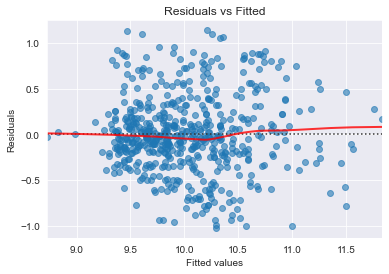

In [35]:
fig_1 = plt.figure(1)
fig_1.axes[0] = sns.residplot(data['hat_log_price'], data['log_price'],
                                  lowess=True,
                                  scatter_kws={'alpha': 0.6},
                                  line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
fig_1.axes[0].set_title('Residuals vs Fitted')
fig_1.axes[0].set_xlabel('Fitted values')
fig_1.axes[0].set_ylabel('Residuals')
plt.show()

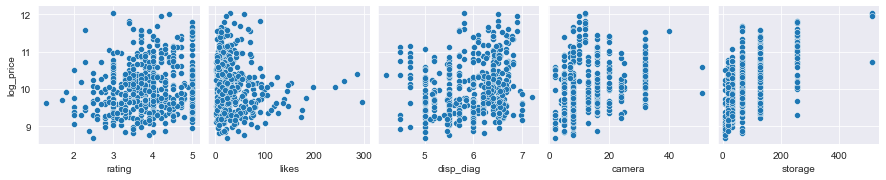

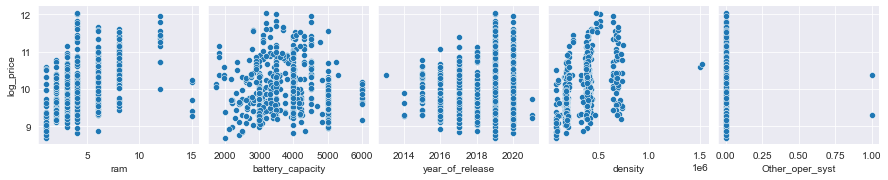

In [36]:
sns.pairplot(data, x_vars=X_columns[0:5], y_vars=["log_price"])
sns.pairplot(data, x_vars=X_columns[5:10], y_vars=["log_price"])
# sns.pairplot(data, x_vars=X_columns[10:15], y_vars=["log_price"]) # Неинтерпретируемые графики
# sns.pairplot(data, x_vars=X_columns[15:20], y_vars=["log_price"]) # Неинтерпретируемые графики
plt.show()

#### 3.1 Тест на проверку гетероскедостичности

$$\begin{align}
&H0: \sigma_{i}^2  = \sigma^2, \forall \ i \in \ \{0,1,2,3,4,5\} \ (гомоскедостичность) \\
&H1: \exists \ i, j : \sigma_{i}^2  \neq \sigma_{k}^2 \ (гетероскедостичность)
\end{align}$$

#### 3.1.1 Тест Уйата

In [37]:
X = data.loc[:, X_columns].copy()
y = data['log_price']
model = sm.OLS(y, X).fit()


In [38]:
white_test = het_white(model.resid,  model.model.exog)


In [39]:
labels = ['Chi^2 observed statistic', 'Chi^2 obserrved statistic p-value', 'F-Statistic', 'F-Test p-value']
res_white = dict(zip(labels, white_test))
print(f"Chi^2 observed statistic: {res_white['Chi^2 observed statistic']}")
# print(f"Chi^2 critical Statistics = {sp.stats.chi2.isf(1-0.1, np.shape(model.model.exog)[1] - 1, loc=0)}") Проверить док
print(f"P-value = {res_white['Chi^2 obserrved statistic p-value']}")

Chi^2 observed statistic: 316.3766655633395
P-value = 3.513471641953569e-06


Нулевая гипотеза о гомоскедостичности остатков отвергается на любом разумном уровне значимости

#### 3.1.2 Бройша-Пагана

In [40]:
bp_test = het_breuschpagan(model.resid,  model.model.exog)
labels = ['Chi^2 observed statistic', 'Chi^2 obserrved statistic p-value', 'F-Statistic', 'F-Test p-value']
res_bp = dict(zip(labels, bp_test))
print(f"Chi^2 observed statistic: {res_bp['Chi^2 observed statistic']}")
# print(f"Chi^2 critical Statistics = {sp.stats.chi2.isf(1-0.1, np.shape(model.model.exog)[1] - 1, loc=0)}")  Проверить док
print(f"P-value = {res_bp['Chi^2 obserrved statistic p-value']}")


Chi^2 observed statistic: 270.72043443458836
P-value = 1.3189775389170226e-39


#### 3.1.3 Тест Голдфелда — Куандта

In [41]:
# goldfeldquandt = het_goldfeldquandt(model.resid,  model.model.exog)
# labels = ['F-statistics observed', 'F-statistics p-value', 'ordering']
# res_goldfeldquandt = dict(zip(labels, goldfeldquandt))
# print(f"F observed statistic: {res_goldfeldquandt['F-statistics observed']}")
# print(f"P-value = {res_goldfeldquandt['F-statistics p-value']}")



### 3.2 Решение проблемы гетероскедостичности

Для решение этой проблемы воспользуюсь робастными оценками в форме Уайта

##### 3.2.1 Общая информации модели до применение робастных оценок

In [42]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     21.42
Date:                Tue, 09 May 2023   Prob (F-statistic):           8.46e-77
Time:                        00:30:40   Log-Likelihood:                -313.67
No. Observations:                 561   AIC:                             695.3
Df Residuals:                     527   BIC:                             842.5
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -59.9743     40.647     -1.475      0.141    -139.824      19.876
rating                0.0647      0.028      2.288      0.023       0.009       0.120
likes                -0.0002      0.001     -0.367      0.713      -0.001       0.001
disp_diag            -0.0255      0.069     -0.369      0.713      -0.161       0.110
camera                0.0077      0.003      2.702      0.007       0.002       0.013
storage               0.0020      0.000      5.467      0.000       0.001       0.003
ram                   0.0551      0.011      4.871      0.000       0.033       0.077
battery_capacity  -4.375e-05   3.92e-05     -1.115      0.265      -0.000    3.34e-05
year_of_release       0.0348      0.020      1.721      0.086      -0.005       0.075
density            4.606e-07   1.47e-07      3.136      0.002    1.72e-07    7.49e-07
Other_oper_syst       0.2207      0.344      0.641      0.522      -0.455       0.897
battery_type_LiPo     0.0332      0.051      0.646      0.518      -0.068       0.134
brand_BlackBerry     -0.8025      0.178     -4.505      0.000      -1.152      -0.453
brand_Cubot          -0.6701      0.242     -2.768      0.006      -1.146      -0.195
brand_Gionee         -1.1187      0.331     -3.382      0.001      -1.768      -0.469
brand_Google         -0.4077      0.169     -2.416      0.016      -0.739      -0.076
brand_HTC            -0.9751      0.127     -7.659      0.000      -1.225      -0.725
brand_Honor          -0.2385      0.225     -1.062      0.289      -0.680       0.203
brand_Hotwav         -1.5796      0.450     -3.511      0.000      -2.463      -0.696
brand_Huawei         -1.0110      0.113     -8.969      0.000      -1.232      -0.790
brand_Infinix        -1.1187      0.129     -8.667      0.000      -1.372      -0.865
brand_LG             -0.5304      0.162     -3.271      0.001      -0.849      -0.212
brand_Lava           -1.6260      0.327     -4.974      0.000      -2.268      -0.984
brand_Lenovo         -0.9960      0.170     -5.866      0.000      -1.329      -0.662
brand_Motorola       -0.3421      0.206     -1.663      0.097      -0.746       0.062
brand_Nokia          -1.0846      0.137     -7.903      0.000      -1.354      -0.815
brand_OnePlus        -0.3547      0.157     -2.259      0.024      -0.663      -0.046
brand_Oppo           -1.0004      0.133     -7.528      0.000      -1.262      -0.739
brand_Realme         -1.0264      0.159     -6.469      0.000      -1.338      -0.715
brand_Samsung        -0.7926      0.111     -7.164      0.000      -1.010      -0.575
brand_Sony           -0.6121      0.166     -3.698      0.000      -0.937      -0.287
brand_Tecno          -0.8960      0.126     -7.100      0.000      -1.144      -0.648
brand_Vivo           -0.8300      0.229     -3.632      0.000      -1.279

##### 3.2.2 Применение робастных оценок

In [43]:
ols_robust = ols.get_robustcov_results()
ols_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     239.3
Date:                Tue, 09 May 2023   Prob (F-statistic):          2.64e-293
Time:                        00:30:40   Log-Likelihood:                -313.67
No. Observations:                 561   AIC:                             695.3
Df Residuals:                     527   BIC:                             842.5
Df Model:                          33                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -59.9743     40.411     -1.484      0.138    -139.360      19.411
rating                0.0647      0.029      2.218      0.027       0.007       0.122
likes                -0.0002      0.000     -0.594      0.553      -0.001       0.001
disp_diag            -0.0255      0.070     -0.362      0.717      -0.164       0.113
camera                0.0077      0.003      2.560      0.011       0.002       0.014
storage               0.0020      0.000      4.439      0.000       0.001       0.003
ram                   0.0551      0.014      3.993      0.000       0.028       0.082
battery_capacity  -4.375e-05   4.08e-05     -1.073      0.284      -0.000    3.64e-05
year_of_release       0.0348      0.020      1.733      0.084      -0.005       0.074
density            4.606e-07   1.47e-07      3.130      0.002    1.72e-07     7.5e-07
Other_oper_syst       0.2207      0.447      0.494      0.622      -0.658       1.099
battery_type_LiPo     0.0332      0.054      0.620      0.535      -0.072       0.138
brand_BlackBerry     -0.8025      0.229     -3.498      0.001      -1.253      -0.352
brand_Cubot          -0.6701      0.117     -5.746      0.000      -0.899      -0.441
brand_Gionee         -1.1187      0.147     -7.603      0.000      -1.408      -0.830
brand_Google         -0.4077      0.269     -1.517      0.130      -0.936       0.120
brand_HTC            -0.9751      0.125     -7.811      0.000      -1.220      -0.730
brand_Honor          -0.2385      0.196     -1.215      0.225      -0.624       0.147
brand_Hotwav         -1.5796      0.108    -14.666      0.000      -1.791      -1.368
brand_Huawei         -1.0110      0.112     -9.050      0.000      -1.230      -0.792
brand_Infinix        -1.1187      0.121     -9.255      0.000      -1.356      -0.881
brand_LG             -0.5304      0.177     -3.000      0.003      -0.878      -0.183
brand_Lava           -1.6260      0.109    -14.972      0.000      -1.839      -1.413
brand_Lenovo         -0.9960      0.122     -8.160      0.000      -1.236      -0.756
brand_Motorola       -0.3421      0.207     -1.651      0.099      -0.749       0.065
brand_Nokia          -1.0846      0.121     -8.992      0.000      -1.322      -0.848
brand_OnePlus        -0.3547      0.131     -2.714      0.007      -0.611      -0.098
brand_Oppo           -1.0004      0.132     -7.561      0.000      -1.260      -0.741
brand_Realme         -1.0264      0.150     -6.838      0.000      -1.321      -0.732
brand_Samsung        -0.7926      0.116     -6.810      0.000      -1.021      -0.564
brand_Sony           -0.6121      0.172     -3.566      0.000      -0.949      -0.275
brand_Tecno          -0.8960      0.135     -6.641      0.000      -1.161      -0.631
brand_Vivo           -0.8300      0.120     -6.940      0.000      -1.065

### 4. Спецификация модели